Install dependencies

In [ ]:
!pip install -r ../../requirements.txt

Import training and testing data.

* {train, test}_images: contains the path of each image
* {train, test}_scores: contains the user ratings of each image

In [1]:
import csv

data_folder = '../../datasets/rating-based-dataset/preprocess/'

train_data_path = data_folder + 'train_list.csv'
test_data_path = data_folder + 'test_list.csv'
images_path = data_folder + 'resized'

def get_scores(scores_path):

    images = []
    scores = []

    with open(scores_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0

        for row in csv_reader:
            if line_count == 0:

                line_count += 1
            else:

                scores.append(float(row[1]))
                line_count += 1
                image_name = row[0]

                images.append(images_path + image_name)


    return (images, scores)


train_images, train_scores = get_scores(train_data_path)
test_images, test_scores = get_scores(test_data_path)

Shuffle the training set

In [2]:
import random
import numpy as np

# np.random.seed(2000)

temp = list(zip(train_images, train_scores))
random.shuffle(temp)

train_images, train_scores = zip(*temp)

Display the first 3 images to make sure everything is ok. 

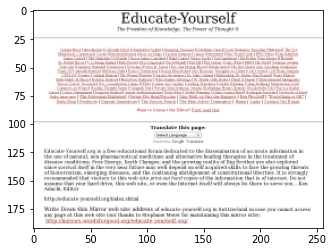

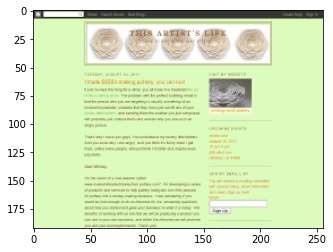

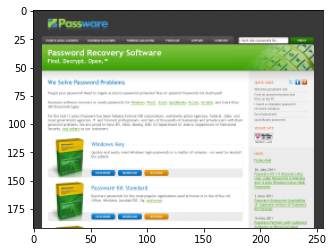

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.image as mping
for ima in train_images[0:3]:
    img = mping.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

Convert data to numpy arrays and display shape to check everything is ok.

In [4]:
X_train_filenames = np.array(train_images)
y_train = np.array(train_scores)
X_val_filenames = np.array(test_images)
y_val = np.array(test_scores)

ntrain = len(X_train_filenames)
nval = len(X_val_filenames)

print('Shape of X_train is: ', X_train_filenames.shape)
print('Shape of X_val is: ', X_val_filenames.shape)
print('Shape of y_train is: ', y_train.shape)
print('Shape of y_val is: ', y_val.shape)

Shape of X_train is:  (280723,)
Shape of X_val is:  (98,)
Shape of y_train is:  (280723,)
Shape of y_val is:  (98,)


Get the weights of the pretrained model. This model is pretrained on the Flickr style dataset (containing 80 K images) for image style recognition task. It aims at the artistic aspect recognition of photographs and it is fine-tuned from another network which has been pretrained on the ImageNet dataset for object recognition task.

In [5]:
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras import initializers

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

import h5py

def traverse_datasets(hdf_file):

    def h5py_dataset_iterator(g, prefix=''):
        for key in g.keys():
            item = g[key]
            path = f'{prefix}/{key}'
            if isinstance(item, h5py.Dataset): # test for dataset
                yield (path, item)
            elif isinstance(item, h5py.Group): # test for group (go down)
                yield from h5py_dataset_iterator(item, path)

    with h5py.File(hdf_file, 'r') as f:
        for path, _ in h5py_dataset_iterator(f):
            yield path
            
weights = {}

filename = '../../pretrained-models/flickr_style.h5'

with h5py.File(filename, 'r') as f:
    for dset in traverse_datasets(filename):
        # print('Shape:', f[dset].shape)
        # print('Data type:', f[dset].dtype)
        weights[dset] = f[dset][:]

conv1_bias = weights['/conv1/conv1/bias:0']
conv1_kernel = weights['/conv1/conv1/kernel:0']
conv2_bias = weights['/conv2/conv2/bias:0']
conv2_kernel = weights['/conv2/conv2/kernel:0']
conv3_bias = weights['/conv3/conv3/bias:0']
conv3_kernel = weights['/conv3/conv3/kernel:0']
conv4_bias = weights['/conv4/conv4/bias:0']
conv4_kernel = weights['/conv4/conv4/kernel:0']
conv5_bias = weights['/conv5/conv5/bias:0']
conv5_kernel = weights['/conv5/conv5/kernel:0']


Using TensorFlow backend.
c:\Users\Abraham\Proyectos\website-aesthetics-research\.venv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Abraham\Proyectos\website-aesthetics-research\.venv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Abraham\Proyectos\website-aesthetics-research\.venv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype

The architecture that will be used for the CNN is AlexNet. First, we define the LRN (Local Response Normalization) layer.

In [6]:
from keras.layers.core import Layer
from keras import backend as K

class LRN(Layer):
    
    def __init__(self, n=5, alpha=0.0001, beta=0.75, k=2, **kwargs):
        self.n = n
        self.alpha = alpha
        self.beta = beta
        self.k = k
        super(LRN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.shape = input_shape
        super(LRN, self).build(input_shape)

    def call(self, x, mask=None):
        if K.common.image_dim_ordering == "th":
            _, f, r, c = self.shape
        else:
            _, r, c, f = self.shape
        half_n = self.n // 2
        squared = K.square(x)
        pooled = K.pool2d(squared, (half_n, half_n), strides=(1, 1),
                         padding="same", pool_mode="avg")
        if K.common.image_dim_ordering == "th":
            summed = K.sum(pooled, axis=1, keepdims=True)
            averaged = (self.alpha / self.n) * K.repeat_elements(summed, f, axis=1)
        else:
            summed = K.sum(pooled, axis=3, keepdims=True)
            averaged = (self.alpha / self.n) * K.repeat_elements(summed, f, axis=3)
        denom = K.pow(self.k + averaged, self.beta)
        return x / denom
    
    def get_output_shape_for(self, input_shape):
        return input_shape

Construct the CNN.

In [7]:
l = 0.001 # weight decay

input_shape = (192, 256, 3)

im_data = layers.Input(shape=input_shape, dtype='float32', name='im_data')

conv1 = layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), name='conv1', 
                        activation='relu', input_shape=input_shape, 
                        kernel_regularizer=regularizers.l2(l))(im_data)

pool1 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)
norm1 = LRN(name="norm1")(pool1)
drop1 = layers.Dropout(0.1)(norm1)

layer1_1 = layers.Lambda(lambda x: x[:, :, :, :48])(drop1)
layer1_2 = layers.Lambda(lambda x: x[:, :, :, 48:])(drop1)

conv2_1 = layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1),
                          activation='relu',
                          padding='same', 
                          name='conv2_1', 
                        kernel_regularizer=regularizers.l2(l))(layer1_1)

conv2_2 = layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 padding='same', 
                 name='conv2_2',
                 kernel_regularizer=regularizers.l2(l))(layer1_2)

conv2 = layers.Concatenate(name='conv_2')([conv2_1, conv2_2])

pool2 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv2)
norm2 = LRN(name="norm2")(pool2)
drop2 = layers.Dropout(0.1)(norm2)

conv3 = layers.Conv2D(384, kernel_size=(3, 3), strides=(1, 1), activation='relu', name='conv3',
                        padding='same',
                        kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                        bias_initializer='zeros',
                        kernel_regularizer=regularizers.l2(l))(drop2)
drop3 = layers.Dropout(0.1)(conv3)

layer3_1 = layers.Lambda(lambda x: x[:, :, :, :192])(drop3)
layer3_2 = layers.Lambda(lambda x: x[:, :, :, 192:])(drop3)

conv4_1 = layers.Conv2D(192, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu', 
                 padding='same',
                 name='conv4_1',
                 kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                 bias_initializer='zeros',
                 kernel_regularizer=regularizers.l2(l))(layer3_1)

conv4_2 = layers.Conv2D(192, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu', 
                 padding='same',
                 name='conv4_2',
                 kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                 bias_initializer='zeros',
                 kernel_regularizer=regularizers.l2(l))(layer3_2)

conv4 = layers.Concatenate(name='conv_4')([conv4_1, conv4_2])

layer4_1 = layers.Lambda(lambda x: x[:, :, :, :192])(conv4)
layer4_2 = layers.Lambda(lambda x: x[:, :, :, 192:])(conv4)

conv5_1 = layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 padding='same', 
                 name='conv5_1',
                 kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                 bias_initializer='zeros',
                 kernel_regularizer=regularizers.l2(l))(layer4_1)

conv5_2 = layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 padding='same', 
                 name='conv5_2',
                 kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                 bias_initializer='zeros',
                 kernel_regularizer=regularizers.l2(l))(layer4_2)

conv5 = layers.Concatenate(name='conv_5')([conv5_1, conv5_2])

pool5 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv5)

flat = layers.Flatten()(pool5)
fc6 = layers.Dense(1024, activation='relu', 
                        kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                        bias_initializer='zeros',
                       kernel_regularizer=regularizers.l2(l))(flat)
drop6 = layers.Dropout(0.5)(fc6)

fc7 = layers.Dense(512, activation='relu',
                        kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                        bias_initializer='zeros',
                       kernel_regularizer=regularizers.l2(l))(drop6)
drop7 = layers.Dropout(0.5)(fc7)

fc8 = layers.Dense(1,
                  kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                  bias_initializer='zeros')(drop7)

model = models.Model(inputs=im_data, outputs=fc8)

# model.summary()








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Initialize the weights of the first 2 convolutional layers of the model with the weights of the pretrained model. 

In [8]:
model.get_layer('conv1').set_weights([conv1_kernel[:, :, :, :], conv1_bias[:]])
model.get_layer('conv2_1').set_weights([conv2_kernel[:, :, :, :128], conv2_bias[:128]])
model.get_layer('conv2_2').set_weights([conv2_kernel[:, :, :, 128:], conv2_bias[128:]])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
im_data (InputLayer)            (None, 192, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 46, 62, 96)   34944       im_data[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 23, 31, 96)   0           conv1[0][0]                      
__________________________________________________________________________________________________
norm1 (LRN)                     (None, 23, 31, 96)   0           max_pooling2d_1[0][0]            
____________________________________________________________________________________________

Define the loss function (Euclidean Distance Loss) and the metric (RMSE) that will be used

In [9]:
from keras import backend as K
 
def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def euclidean_distance_loss(y_true, y_pred):
    return 0.5 * K.mean(K.square(y_pred - y_true), axis=-1)

Define a generator to load the training data in batches.

In [10]:
from keras import utils
import cv2

class My_Custom_Generator(utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
      

    return np.array([
            cv2.imread(str(file_name), cv2.IMREAD_COLOR)
               for file_name in batch_x]) / 255.0, np.array(batch_y)


In [11]:
batch_size = 64

train_generator = My_Custom_Generator(X_train_filenames, y_train, batch_size)
val_generator = My_Custom_Generator(X_val_filenames, y_val, 98)

Compile the model. Use RMSE to measure performance.

In [12]:
epochs = 4
decay = 1e-2
base_lr = 0.001

sgd = optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(loss=euclidean_distance_loss , optimizer=sgd, metrics=[rmse])

Train the model.

In [13]:
history = model.fit_generator(train_generator, 
                             steps_per_epoch = ntrain // batch_size,
                             epochs = epochs, 
                             validation_data=val_generator,
                             validation_steps=nval // 98)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/4
4386/4386 [==============================] - 6010s 1s/step - loss: 3.3350 - rmse: 1.5929 - val_loss: 1.7167 - val_rmse: 0.5682
Epoch 2/4
4386/4386 [==============================] - 6880s 2s/step - loss: 3.1884 - rmse: 1.5341 - val_loss: 1.6633 - val_rmse: 0.5212
Epoch 3/4
4386/4386 [==============================] - 6988s 2s/step - loss: 3.1582 - rmse: 1.5205 - val_loss: 1.6493 - val_rmse: 0.5150
Epoch 4/4
 696/4386 [===>..........................] - ETA: 1:23:37 - loss: 3.1435 - rmse: 1.5139

KeyboardInterrupt: 

Display the learning curves.

In [ ]:
rmse = history.history["rmse"]
val_rmse = history.history["val_rmse"]

epochs_x = range(1, len(rmse) + 1)

plt.plot(epochs_x, rmse, 'b', label='Training RMSE')
plt.plot(epochs_x, val_rmse, 'r', label='Validation RMSE')

plt.legend()

Define a function that calculates Pearson correlation. 

In [ ]:
from scipy import stats

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''
    N = len(x)
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(N-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

Load the images of the testing set.

In [ ]:
import cv2

def read_and_process_images(list_of_images):
  X = []
  
  for image in list_of_images:
    X.append(np.array(cv2.imread(image, cv2.IMREAD_COLOR)) / 255.0)

  
  return X

X_val = np.array(read_and_process_images(test_images))
y_val = np.array(test_scores)

print(X_val.shape)
print(y_val.shape)

Predict the scores for the images in the testing set. Display the predictions of the first 10 images.

In [ ]:
predictions = []

for img in X_val:
  img = img.reshape(1, 192, 256, 3)
  pred = model.predict(img)
  predictions.append(float(pred))

predictions = np.array(predictions)

Display some websites of the test set and the predicted aesthetics score.

In [ ]:
image_ids = [87, 45, 49, 94, 14, 83] # test image IDs sorted in descending order according to the website's aesthetics level

fig = plt.figure(figsize=(12, 16))
i = 1
for id in image_ids:
  if 'english' in test_images[id]:
    path = images_path + '/english_resized/' + test_images[id].rsplit('/', 1)[1]
  else:
    path = images_path + '/foreign_resized/' + test_images[id].rsplit('/', 1)[1]

  plt.subplot(len(image_ids)/2, 2, i)
  img = mping.imread(path)
  plt.title('User average rating: ' + str(np.round(y_val[id],2)) + '\nPredicted rating: ' + str(np.round(predictions[id],2)) + '\n(' + chr(97+i-1) + ')', y=-0.25)
  plt.axis('off')
  plt.imshow(img)
    
  i += 1

plt.show()

Create a scatterplot to check the relationship between ground truth and predicted scores.

In [ ]:
from numpy.polynomial.polynomial import polyfit
b, m = polyfit(y_val, predictions, 1)

fig = plt.figure()
plt.scatter(y_val, predictions, c='c')
plt.plot(y_val, b + m * y_val, '-', c='b')
plt.xlabel('User ratings')
plt.ylabel('Predicted ratings')

plt.show()

Calculate the Pearson correlation and the RMSE between ground truth and predicted scores.

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

corr, p, lo, hi = pearsonr_ci(y_val, predictions)
print('Pearsons correlation: r=%.2f, p=%.2e, CI=[%.2f, %.2f]' % (corr, p, lo, hi))
rmse_test = sqrt(mean_squared_error(y_val, predictions))
print('RMSE: %.3f' % rmse_test)

Plot the distribution of ground truth scores and the distribution of predictions.

In [ ]:
import seaborn as sns

fig = plt.figure()
sns.set(color_codes=True)

bins = np.linspace(1, 9, num=15)

sns.distplot(y_val, bins=bins, label='User ratings')

sns.distplot(predictions, bins=bins, label='Predicted ratings')

plt.legend()

plt.show()